In [1]:
!pip install xgboost

In [2]:
!pip install imblearn

In [3]:
import sklearn
import pandas
import xgboost
import numpy
import imblearn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.6 MB/s eta 0:00:00


In [6]:
!pip install skfeature-chappers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 1.1 MB/s eta 0:00:00


In [7]:
import pyreadstat
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats as st
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skfeature.function.similarity_based import fisher_score
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform, randint
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import RocCurveDisplay

In [8]:


#The orginal dataset had been readed
df=pd.read_sas('/content/drive/MyDrive/ADHD/file/nsch_2021_topical_SAS/nsch_2021_topical.sas7bdat')


#age filtering
df_1=df[df.SC_AGE_YEARS>=7]



#mannualy choosen features

ddf=df_1[['ALLERGIES_DESC','K2Q40C','K2Q42C','HEART_DESC','HEADACHE_DESC','K2Q38C','K2Q33C','K2Q32C',
          'CYSTFIB_DESC','GENETIC_DESC','K2Q34C','K2Q36C','K2Q60C','K2Q37C','K2Q30C','K2Q35C','K2Q40A',
          'K2Q41A','K2Q42A','HEART','HEADACHE','K2Q38A','K2Q33A','K2Q32A','DOWNSYN','BLOOD','CYSTFIB',
          'GENETIC','K2Q34A','K2Q34B','K2Q36A','K2Q60A','K2Q37A','K2Q30A','K2Q35A']]

df_chose=df_1[['EYEDOCTOR','TOTKIDS_R','TENURE','SC_AGE_YEARS','SC_SEX','MOMAGE','A1_AGE','A2_AGE','HHCOUNT',
               'FAMCOUNT','MEMORYCOND','WALKSTAIRS','DRESSING','K2Q43B','BLINDNESS','CONCUSSION','K2Q05','OVERWEIGHT',
               'VISIONEXAMREC','K4Q23','ISSUECOST','K7Q30','K7Q31','K7Q32','K7Q37','K7Q38','K8Q35','K11Q61','K10Q11',
               'K10Q12','K10Q13','K10Q14','K10Q20','K10Q23','ACE3','ACE4','ACE5','ACE6','ACE7','ACE8','ACE9','ACE10',
               'ACE12','ACE11','A1_SEX','A2_SEX','A1_EMPLOYED','A1_GRADE','A2_EMPLOYED','A2_GRADE','A1_PHYSHEALTH',
               'A1_MENTHEALTH','A2_PHYSHEALTH','A2_MENTHEALTH','K2Q01','K6Q71_R','K7Q84_R','K7Q85_R','K7Q82_R','K7Q70_R',
               'BULLIED_R','BULLY','K10Q31','K10Q40_R','K8Q31','K8Q32','K8Q34','K7Q02R_R','K7Q04R_R','PHYSACTIV','HOURSLEEP05',
               'HOURSLEEP','SCREENTIME','K8Q11','FOODSIT','K4Q30_R_3','K4Q22_R','HOSPITALER','S4Q01','K8Q21','K8Q30','K7Q33','BEDTIME',
               'ACE1','MAKEFRIEND','MPC_YN','TOTAGE_0_5','TOTAGE_6_11','TOTAGE_12_17','TOTCSHCN','SC_RACE_R','SC_K2Q13','SC_K2Q16','SC_K2Q17',
               'SC_K2Q22','AGEPOS4','TOTMALE','TOTFEMALE','BIRTHWT_OZ_S','FAMILY_R','HIGRADE_TVIS','FPL_I1','FPL_I2','FPL_I3','FPL_I4','FPL_I5','FPL_I6','FWC']]

df_chose_1=pd.concat([df_chose,ddf],axis=1)



#label for ADHD detection
label=abs(df_1[['K2Q31A']]-2)
df_chose_2=pd.concat([df_chose_1,label['K2Q31A']],axis=1)




#droping subjects that have Nan value in the label column
df_chose_with_dropna=df_chose_2.dropna(subset=['K2Q31A'])



#fill missing values



means=df_chose_with_dropna.median()
df_chose_with_dropna=df_chose_with_dropna.fillna(means,axis=0)
df_chose_with_dropna=df_chose_with_dropna.dropna(axis=1)
df_chose_with_dropna.to_csv('/content/drive/MyDrive/ADHD/file/dataset_median.csv')



In [9]:
class Preprocessor():
  def __init__(self):
    df=pd.read_csv('/content/drive/MyDrive/ADHD/file/dataset_median.csv')
    self.df=df.drop(columns=['Unnamed: 0'])
    self.X=self.df.drop(columns=['K2Q31A'])
    self.y=self.df['K2Q31A']

  def information_gain(self):
    importances=mutual_info_classif(self.X,self.y)
    feat_importances=pd.Series(importances,self.X.columns[0:len(self.X)-1])
    feat_importances.sort_values(ascending=False).to_csv('/content/drive/MyDrive/ADHD/feature_dataset/information_gain_medain.csv')
    return feat_importances.sort_values(ascending=False).index,feat_importances.sort_values(ascending=False).values

  def fisher(self):
    best_features = SelectKBest(score_func=f_classif, k=60)
    fit = best_features.fit(self.X, self.y)

    # # print the scores and p-values for each feature
    dfscores = pd.DataFrame(fit.scores_)
    dfpvalues = pd.DataFrame(fit.pvalues_)
    dfcolumns = pd.DataFrame(self.X.columns)
    feature_scores = pd.concat([dfcolumns, dfscores, dfpvalues], axis=1)
    feature_scores.columns = ['Feature', 'Score', 'p-value']
    feature_scores.sort_values('Score',ascending=False).to_csv('/content/drive/MyDrive/ADHD/feature_dataset/fisher_median.csv')
    return feature_scores.sort_values('Score',ascending=False)

    # ranks=fisher_score.fisher_score(self.X,self.y)
    # feat_importance=pd.Series(ranks, self.X.columns[0:len(self.X.columns)-1])
    # return feat_importance
  def cor(self):
    corr=self.df.corr()
    abs(corr.K2Q31A).sort_values(ascending=False).drop(['K2Q31A']).to_csv('/content/drive/MyDrive/ADHD/feature_dataset/cor_median.csv')
    return abs(corr.K2Q31A).sort_values(ascending=False).drop(['K2Q31A']).index , abs(corr.K2Q31A).sort_values(ascending=False).drop(['K2Q31A']).values

  def chi_square(self):
    best_features = SelectKBest(score_func=chi2, k=60)
    fit = best_features.fit(self.X, self.y)
    dfscores = pd.DataFrame(fit.scores_)
    dfpvalues = pd.DataFrame(fit.pvalues_)
    dfcolumns = pd.DataFrame(self.X.columns)
    feature_scores = pd.concat([dfcolumns, dfscores, dfpvalues], axis=1)
    feature_scores.columns = ['Feature', 'Score', 'p-value']
    feature_scores.sort_values('Score',ascending=False).to_csv('/content/drive/MyDrive/ADHD/feature_dataset/chi_median.csv')
    return feature_scores.sort_values('Score',ascending=False)


In [10]:
p=Preprocessor()
inf=p.information_gain()
chi=p.chi_square()
corr=p.cor()
fish=p.fisher()

In [11]:
class Dataset():
    def __init__(self):

        # whole dataset
        df = pd.read_csv('/content/drive/MyDrive/ADHD/file/dataset_median.csv')
        self.y = df['K2Q31A']
        self.X = df.drop(columns='K2Q31A')
        self.features=pd.read_csv('/content/drive/MyDrive/ADHD/file/feature_median.csv')

        # chi square
        self.chi=self.features.Chi

        # fisher's score
        self.fisher=self.features.Fisher

        # information gain
        self.inf=self.features.Information_gain

        # corelation
        self.cor=self.features.Cor


    def return_dataset(self) -> pd.DataFrame:
        return self.X, self.y

    def return_chi(self) -> pd.Series:
        return self.chi

    def return_fisher(self) -> pd.Series:
        return self.fisher

    def return_inf(self) -> pd.Series:
        return self.inf

    def return_cor(self) -> pd.Series:
        return self.cor

    # intersections of 2 sets
    def return_intersection_chi_fisher(self) -> list:
        return list(set(self.chi.tolist()) & set(self.fisher.tolist()))

    def return_intersection_chi_inf(self) -> list:
        return list(set(self.chi.tolist()) & set(self.inf.tolist()))

    def return_intersection_chi_cor(self) -> list:
        return list(set(self.chi.tolist()) & set(self.cor.tolist()))

    def return_intersection_fisher_inf(self) -> list:
        return list(set(self.fisher.tolist()) & set(self.inf.tolist()))

    def return_intersection_fisher_cor(self) -> list:
        return list(set(self.fisher.tolist()) & set(self.cor.tolist()))

    def return_intersection_inf_cor(self) -> list:
        return list(set(self.inf.tolist()) & set(self.cor.tolist()))

    # intersections of 3 sets
    def return_intersection_chi_fisher_inf(self) -> list:
        return list(set(self.chi.tolist()) & set(self.fisher.tolist()) & set(self.inf.tolist()))

    def return_intersection_chi_fisher_cor(self) -> list:
        return list(set(self.chi.tolist()) & set(self.fisher.tolist()) & set(self.cor.tolist()))

    def return_intersection_chi_inf_cor(self) -> list:
        return list(set(self.chi.tolist()) & set(self.inf.tolist()) & set(self.cor.tolist()))

    def return_intersection_fisher_inf_cor(self) -> list:
        return list(set(self.fisher.tolist()) & set(self.inf.tolist()) & set(self.cor.tolist()))


    def return_all_intersection(self) -> list:
      return list(set(self.fisher.tolist()) & set(self.inf.tolist()) & set(self.cor.tolist()) & set(self.chi.tolist()))




In [12]:
class Model():
    def __init__(self, no_iters: int, selection: list, x: pd.DataFrame, y: pd.DataFrame, filename: str):

        self.no_iters = no_iters

        self.x = x.loc[:, x.columns.isin(selection)]
        self.y = y


        self.filename = str(self._create_filename(filename) + '.text').replace("'", "")



        self.xgboost_classifier=XGBClassifier(objective='binary:logistic',gamma=5,
                                              learning_rate=0.1, 	max_depth=5,
                                              n_estimators=200, seed=42,)

        self.adaboost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=200,
        learning_rate=0.1,
        algorithm='SAMME',
        random_state=42)

        self.svm_classifier = SVC(C=1 ,	gamma=0.1 ,	kernel='rbf' ,probability=True	)

        self.random_forest_classifier = RandomForestClassifier(max_depth=10 ,	max_features=25, 	min_samples_split=10, 	n_estimators=200)

        self.gradient_boost_classifier = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,min_samples_split=5,n_estimators=100)

        self.decision_tree_classifier= DecisionTreeClassifier( 	max_depth=5, 	min_samples_leaf=5 ,	min_samples_split=10)

        self.logistic_regression=LogisticRegression(random_state=0,max_iter=1000,solver='newton-cholesky',C=1,penalty="l2")

        self.gaussian_NB=GaussianNB(var_smoothing=1e-9)

        self.knn=KNeighborsClassifier(n_neighbors=7,p=1,weights='uniform')

        #ensemble learning classifier uses the object classifer as input
        # self.ensemble_classifier=EnsembleModel([self.xgboost_classifier,self.gradient_boost_classifier,self.adaboost_classifier,self.decision_tree_classifier,self.random_forest_classifier,self.logistic_regression])


        # undersampling
        self.undersample = RandomUnderSampler(sampling_strategy='majority',random_state=9)
        self.X_us , self.y_us= self.undersample.fit_resample(self.x, self.y)


    def return_data(self) -> pd.DataFrame:
      return self.X_us,self.y_us

    def _append_items(self, target: list, name, acc, f1_score, recall, precision, time, no_iters):
        target.append(name)
        target.append(acc)
        target.append(f1_score)
        target.append(recall)
        target.append(precision)
        target.append(time)
        target.append(no_iters)
        return target

    def _train(self, classifier, random_state=0):

        X_train, X_test, y_train, y_test = train_test_split(self.X_us, self.y_us, test_size=0.2)

        start_time = time.time()

        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)

        end_time = time.time()

        time0 = end_time - start_time
        accuracy = accuracy_score(y_test, y_pred) * 100
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)



        return accuracy, f1, recall, precision, time0
    # [name, acc, f1_score, recall, precision, time]


    def display_result(self, result, print_result=True):
        filename ='/content/drive/MyDrive/ADHD/results/files/'+str(self.filename)
        with open(filename, 'a') as file:
            result_string = (f'algorithm name: {result[0]}\n'
                f'number of iterations: {str(self.no_iters)}\n'
                f'average accuracy: {(result[1]).mean():.4f}' + '\n'
                f'max accuracy: {(result[1]).max():.4f}' + '\n'
                f'std accuracy: {(result[1]).std():.4f}' + '\n'
                f'average f1 score: {(result[2]).mean():.4f}' + '\n'
                f'max f1 score: {(result[2]).max():.4f}' + '\n'
                f'std f1 score: {(result[2]).std():.4f}' + '\n'
                f'average recall: {(result[3]).mean():.4f}' + '\n'
                f'max recall: {(result[3]).max():.4f}' + '\n'
                f'std recall: {(result[3]).std():.4f}' + '\n'
                f'average precision: {(result[4]).mean():.4f}' + '\n'
                f'max precision: {(result[4]).max():.4f}' + '\n'
                f'std precision: {(result[4]).std():.4f}' + '\n'
                f'average time: {result[5].mean():.4f}' + '\n\n\n')
            if print_result:
                print(result_string)
            file.write(result_string)
        file.close()
    def roc(self,classifier):
      max_acc=0
      c=0
      for _ in range(self.no_iters):
        c+=1
        print('\r' + str(c), end='')

        X_train, X_test, y_train, y_test = train_test_split(self.X_us, self.y_us, test_size=0.2)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        yp=classifier.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        if accuracy>max_acc:
          fpr,tpr,_=roc_curve(y_test.to_numpy(),yp[:,1],pos_label=1)
      return fpr,tpr

    def fit_algorithm(self, classifier):

        scores = []
        times = []
        f1_scores = []
        recall_scores = []
        precision_scores = []
        max_acc=0
        c=0
        for _ in range(self.no_iters):
            c+=1
            print('\r' + str(c), end='')
            accuracy, f1, recall, precision, time0= self._train(classifier)

            scores.append(accuracy)
            f1_scores.append(f1)
            recall_scores.append(recall)
            precision_scores.append(precision)
            times.append(time0)


        target = []


        name = classifier
        if  name == self.xgboost_classifier:
            name = XGBClassifier.__name__
        # if name==self.ensemble_classifier:
        #     name = EnsembleModel.__name__

        target = self._append_items(target=target, name=name, acc=np.array(scores),
                            f1_score=np.array(f1_scores), recall=np.array(recall_scores),
                            precision=np.array(precision_scores), time=np.array(times), no_iters=self.no_iters)



        self.display_result(target)

    def _create_filename(self, filename):
        index = filename.find("return_")
        if index == -1:
            return None
        else:
            return filename[index + len("return_"):]



In [13]:
dataset  = Dataset()
X, y = dataset.return_dataset()


In [14]:
no_iterarion=1
models=[
    Model(no_iters=no_iterarion, selection=dataset.return_chi(), x=X, y=y,filename=dataset.return_chi.__name__),
    Model(no_iters=no_iterarion, selection=dataset.return_inf(), x=X, y=y,filename=dataset.return_inf.__name__),
    Model(no_iters=no_iterarion, selection=dataset.return_fisher(), x=X, y=y,filename=dataset.return_fisher.__name__),

    Model(no_iters=no_iterarion,selection=dataset.return_intersection_chi_fisher(),x=X, y=y,filename=dataset.return_intersection_chi_fisher.__name__),
    Model(no_iters=no_iterarion,selection=dataset.return_intersection_fisher_inf(),x=X, y=y,filename=dataset.return_intersection_fisher_inf.__name__),
    Model(no_iters=no_iterarion,selection=dataset.return_intersection_chi_inf(),x=X, y=y,filename=str(dataset.return_intersection_chi_inf.__name__)),
    Model(no_iters=no_iterarion,selection=dataset.return_intersection_chi_fisher_inf(),x=X, y=y, filename=dataset.return_intersection_chi_fisher_inf.__name__)#,


    ]

def hyperparam_tuning(models,classifier,param):
  c=0
  result=[]
  accuracy=[]
  for model in models:
    c+=1
    print(c,end='   ')

    r_search = GridSearchCV(classifier, param_grid=param, cv=5)

    X1,y1=model.return_data()
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
    r_search.fit(X_train, y_train)
    y_pred = r_search.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    result.append((r_search.best_params_,r_search.best_score_))
  return result , accuracy

In [15]:
params = {
    'learning_rate': [0.01, 0.1, 0.003],
    'n_estimators': [200, 100, 150],
    'max_depth': [3, 5, 7],
    'gamma': [0, 1, 5]
}

xgb = XGBClassifier(objective='binary:logistic', seed=42)
res,acc=hyperparam_tuning(models, xgb , params)

1   2   3   4   5   6   7   

In [16]:
results=[]
score=[]
for re in res:
  score.append(re[1])
  results.append(re[0])
r_xgb=pd.DataFrame(results)
s_xgb=pd.DataFrame(score)
r_xgb['score']=s_xgb
# pd.DataFrame(results).mode()
r_xgb.sort_values('score',ascending=False)

,gamma,learning_rate,max_depth,n_estimators,score
1,1,0.01,5,150,0.864176
0,5,0.10,3,200,0.863590
4,5,0.01,7,100,0.863590
2,5,0.01,7,200,0.863443
3,5,0.01,5,100,0.863297
5,5,0.01,5,100,0.863150
6,1,0.10,3,200,0.863004


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [17]:
params_ada = {
    'n_estimators': [150, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
res_1,acc_1=hyperparam_tuning(models, ada_clf , params_ada)

results_1=[]
score_1=[]
for re in res_1:
  score_1.append(re[1])
  results_1.append(re[0])
r_ada=pd.DataFrame(results_1)
s_ada=pd.DataFrame(score_1)
r_ada['score']=s_ada
# pd.DataFrame(results).mode()
r_ada.sort_values('score',ascending=False)

1   2   3   4   5   6   7   

,algorithm,estimator,learning_rate,n_estimators,score
0,SAMME,DecisionTreeClassifier(max_depth=3),0.1,200,0.864615
6,SAMME,DecisionTreeClassifier(max_depth=3),0.1,200,0.863736
2,SAMME,DecisionTreeClassifier(max_depth=3),0.1,100,0.862711
5,SAMME,DecisionTreeClassifier(max_depth=3),0.1,100,0.862711
4,SAMME,DecisionTreeClassifier(max_depth=3),0.1,150,0.862271
1,SAMME,DecisionTreeClassifier(max_depth=3),0.1,150,0.861978
3,SAMME,DecisionTreeClassifier(max_depth=3),0.1,200,0.861538


from matplotlib import pyplot as plt
_df_0['n_estimators'].plot(kind='hist', bins=20, title='n_estimators')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='n_estimators', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['n_estimators']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('n_estimators')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['learning_rate']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'learning_rate'}, axis=1)
              .sort_values('learning_rate', ascending=True))
  xs = counted['learning_rate']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['n_estimators'].plot(kind='line', figsize=(8, 4), title='n_estimators')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [18]:
params_svm = {'C': [0.1, 1, 7], 'gamma': [0.1, 1, 7], 'kernel': ['rbf']}
svm_model = SVC()
res_2,acc_2=hyperparam_tuning(models, svm_model , params_svm)

results_2=[]
score_2=[]
for re in res_2:
  score_2.append(re[1])
  results_2.append(re[0])
r_svm=pd.DataFrame(results_2)
s_svm=pd.DataFrame(score_2)
r_svm['score']=s_svm
# pd.DataFrame(results).mode()
r_svm.sort_values('score',ascending=False)


1   2   3   4   5   6   7   

,C,gamma,kernel,score
4,1,0.1,rbf,0.853626
6,1,0.1,rbf,0.852747
3,1,0.1,rbf,0.841172
2,1,0.1,rbf,0.838828
1,7,0.1,rbf,0.690989
5,7,0.1,rbf,0.690256
0,7,0.1,rbf,0.509744


In [19]:
param_rf = {'n_estimators': [100, 300, 200], 'max_depth': [5, 10, 7], 'max_features': [5, 10, 25], 'min_samples_split': [2, 5, 10]}
rf_model = RandomForestClassifier()

res_3,acc_3=hyperparam_tuning(models, rf_model , param_rf)

results_3=[]
score_3=[]
for re in res_3:
  score_3.append(re[1])
  results_3.append(re[0])
r_rf=pd.DataFrame(results_3)
s_rf=pd.DataFrame(score_3)
r_rf['score']=s_rf
# pd.DataFrame(results).mode()
r_rf.sort_values('score',ascending=False)

1   2   3   4   5   6   7   

,max_depth,max_features,min_samples_split,n_estimators,score
1,10,25,2,200,0.865495
4,7,25,10,100,0.865201
2,10,25,2,200,0.864469
0,7,25,10,300,0.863590
5,7,25,10,200,0.863150
6,7,25,5,200,0.863004
3,7,25,10,200,0.862564


In [20]:
param_gb = {'n_estimators': [100, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 1.0], 'min_samples_split': [2, 5, 10]}

gb_model=GradientBoostingClassifier()
res_4,acc_4=hyperparam_tuning(models, gb_model , param_gb)

results_4=[]
score_4=[]
for re in res_4:
  score_4.append(re[1])
  results_4.append(re[0])
r_gb=pd.DataFrame(results_4)
s_gb=pd.DataFrame(score_4)
r_gb['score']=s_gb
# pd.DataFrame(results).mode()
r_gb.sort_values('score',ascending=False)

1   2   3   4   5   6   7   

,learning_rate,max_depth,min_samples_split,n_estimators,score
1,0.10,3,5,100,0.865055
0,0.01,5,5,200,0.863590
4,0.10,3,2,100,0.863443
2,0.01,5,2,100,0.863150
5,0.10,3,5,100,0.862711
6,0.10,3,2,100,0.862711
3,0.01,5,5,100,0.861978


In [21]:
param_dt = {'max_depth': [3, 5, 10, 20], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 5, 10]}

# Define the Decision Tree Classifier model
dt_model = DecisionTreeClassifier()

res_5,acc_5=hyperparam_tuning(models, dt_model , param_dt)
results_5=[]
score_5=[]
for re in res_5:
  score_5.append(re[1])
  results_5.append(re[0])
r_dt=pd.DataFrame(results_5)
s_dt=pd.DataFrame(score_5)
r_dt['score']=s_dt
# pd.DataFrame(results).mode()
r_dt.sort_values('score',ascending=False)


1   2   3   4   5   6   7   

,max_depth,min_samples_leaf,min_samples_split,score
2,5,5,2,0.860952
4,5,5,10,0.859780
1,5,5,10,0.859634
5,5,5,2,0.859048
3,5,5,2,0.858608
6,5,5,5,0.857729
0,5,2,10,0.855092


In [22]:
param_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
nb_model = GaussianNB()

res_6,acc_6=hyperparam_tuning(models, nb_model , param_nb)
results_6=[]
score_6=[]
for re in res_6:
  score_6.append(re[1])
  results_6.append(re[0])
r_nb=pd.DataFrame(results_6)
s_nb=pd.DataFrame(score_6)
r_nb['score']=s_nb
# pd.DataFrame(results).mode()
r_nb.sort_values('score',ascending=False)


1   2   3   4   5   6   7   

,var_smoothing,score
6,1.000000e-09,0.819780
3,1.000000e-09,0.819194
5,1.000000e-09,0.818462
0,1.000000e-09,0.816557
4,1.000000e-05,0.815678
1,1.000000e-09,0.814505
2,1.000000e-05,0.813333


In [23]:
param_knn = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}

knn_model = KNeighborsClassifier()

res_7,acc_7=hyperparam_tuning(models, knn_model , param_knn)
results_7=[]
score_7=[]
for re in res_7:
  score_7.append(re[1])
  results_7.append(re[0])
r_knn=pd.DataFrame(results_7)
s_knn=pd.DataFrame(score_7)
r_knn['score']=s_knn
# pd.DataFrame(results).mode()
r_knn.sort_values('score',ascending=False)

1   2   3   4   5   6   7   

,n_neighbors,p,weights,score
4,7,1,uniform,0.794432
6,11,1,uniform,0.793553
3,11,1,uniform,0.781099
2,11,2,uniform,0.778901
5,7,1,distance,0.712234
1,5,1,distance,0.705201
0,5,1,distance,0.585788


In [24]:
param_lr = {'C': [0.1, 1.0, 10.0], 'penalty': ['l2'], 'solver': ['newton-cg']}

lr_model=LogisticRegression(random_state=0,max_iter=1000)

res_8,acc_8=hyperparam_tuning(models, lr_model , param_lr)
results_8=[]
score_8=[]
for re in res_8:
  score_8.append(re[1])
  results_8.append(re[0])
r_lr=pd.DataFrame(results_8)
s_lr=pd.DataFrame(score_8)
r_lr['score']=s_lr
# pd.DataFrame(results).mode()
r_lr.sort_values('score',ascending=False)


1   2   3   4   5   6   7   

,C,penalty,solver,score
1,1.0,l2,newton-cg,0.860220
4,10.0,l2,newton-cg,0.860220
2,1.0,l2,newton-cg,0.858608
6,10.0,l2,newton-cg,0.857729
5,10.0,l2,newton-cg,0.857436
0,0.1,l2,newton-cg,0.856850
3,1.0,l2,newton-cg,0.855971


In [25]:
no_iterarion =100

In [26]:
dataset  = Dataset()
X, y = dataset.return_dataset()


In [27]:
dataset.return_intersection_chi_fisher_inf().sort()==dataset.return_intersection_chi_inf().sort()


True

In [32]:
dataset  = Dataset()
X, y = dataset.return_dataset()

models=[
    Model(no_iters=no_iterarion, selection=dataset.return_chi(), x=X, y=y,filename=dataset.return_chi.__name__),
    Model(no_iters=no_iterarion, selection=dataset.return_inf(), x=X, y=y,filename=dataset.return_inf.__name__),
    Model(no_iters=no_iterarion, selection=dataset.return_cor(), x=X, y=y,filename=dataset.return_cor.__name__),
    Model(no_iters=no_iterarion,selection=dataset.return_intersection_chi_cor(),x=X, y=y,filename=dataset.return_intersection_chi_cor.__name__),
    Model(no_iters=no_iterarion,selection=dataset.return_intersection_inf_cor(),x=X, y=y,filename=dataset.return_intersection_inf_cor.__name__),
    Model(no_iters=no_iterarion,selection=dataset.return_intersection_chi_inf(),x=X, y=y,filename=str(dataset.return_intersection_chi_inf.__name__)),
    Model(no_iters=no_iterarion,selection=dataset.return_intersection_chi_fisher_inf(),x=X, y=y, filename=dataset.return_intersection_chi_fisher_inf.__name__)

    ]



In [33]:
import os

name_of_file = ['CHI.png', 'INF.png', 'COR.png', 'CHI_COR.png', 'INF_COR.png', 'CHI_INF_.png', 'CHI_FHISHER_INF.png']

100

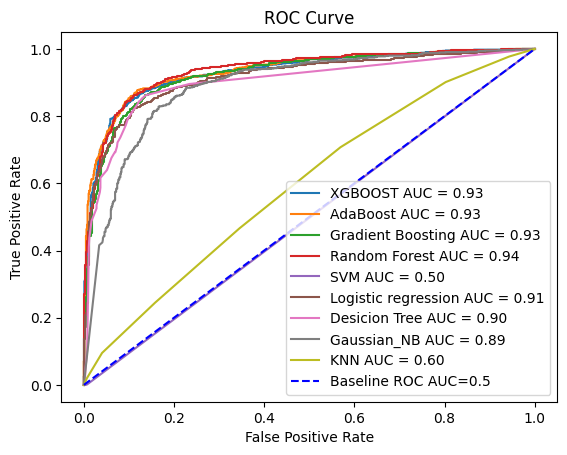

100

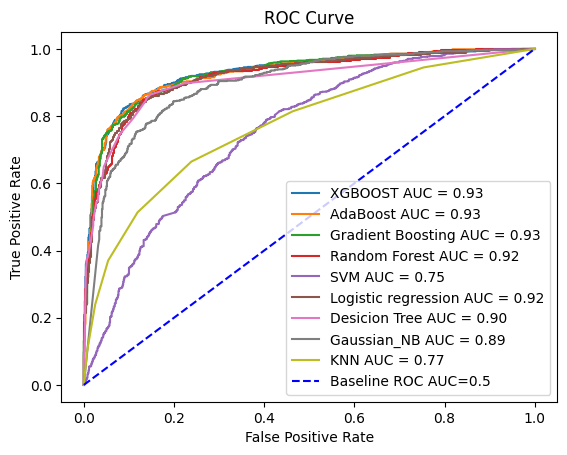

100

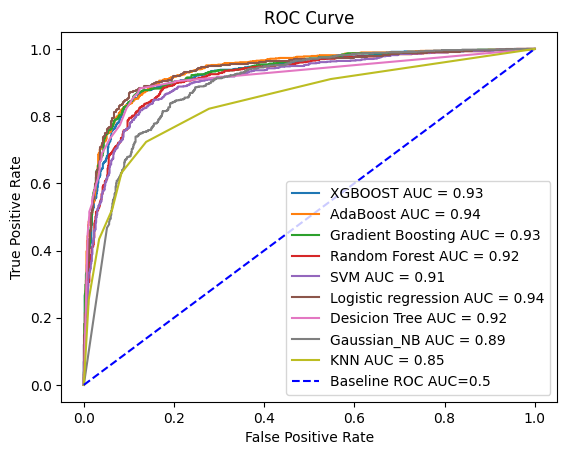

100

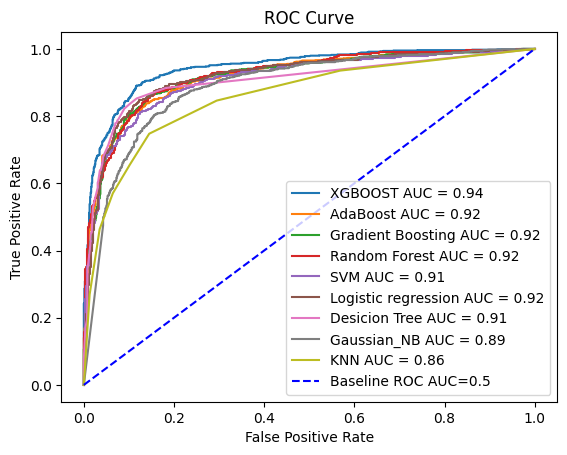

100

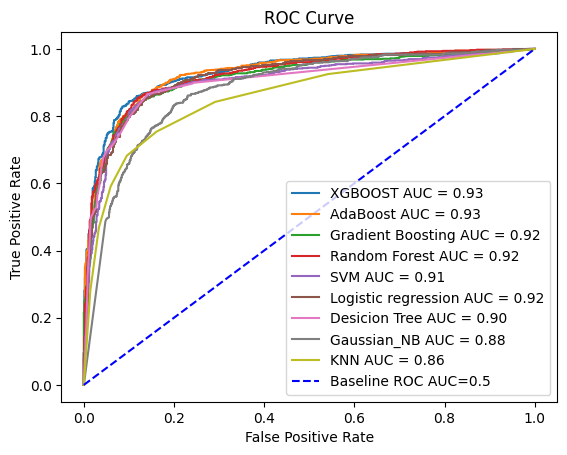

100

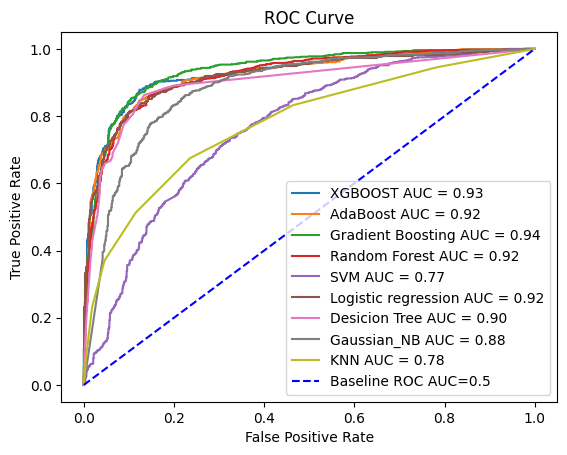

100

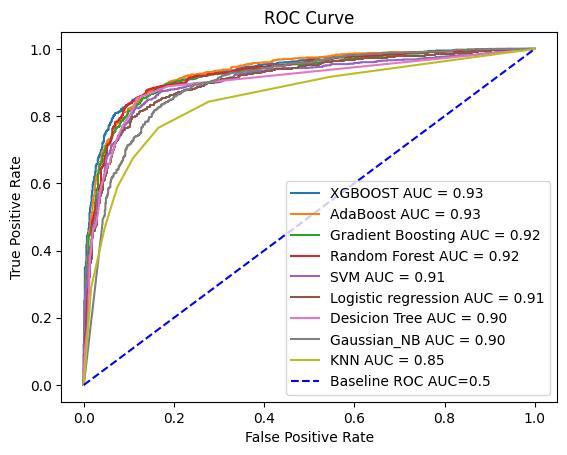

In [40]:


for model in models:
    rate = []
    classifiers = [
        model.xgboost_classifier,
        model.adaboost_classifier,
        model.gradient_boost_classifier,
        model.random_forest_classifier,
        model.svm_classifier,
        model.logistic_regression,
        model.decision_tree_classifier,
        model.gaussian_NB,
        model.knn
    ]

    for classifier in classifiers:
        rate.append(model.roc(classifier=classifier))

    name = ['XGBOOST', 'AdaBoost', 'Gradient Boosting', 'Random Forest', 'SVM', 'Logistic regression', 'Desicion Tree', 'Gaussian_NB', 'KNN']

    for i in range(len(name)):
        plt.plot(rate[i][0], rate[i][1], label=f'{name[i]} AUC = {auc(rate[i][0],rate[i][1]):.2f}')

    plt.plot([0,1],[0,1],'--', c ='blue', label='Baseline ROC AUC=0.5')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Save the plot with the corresponding file name from name_of_file
    if len(name_of_file) > 0:
        plt.savefig(os.path.join('/content/drive/MyDrive/ADHD/results/ROC_curves', name_of_file.pop(0)))

    plt.show()